In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
sns.set(rc={'figure.figsize':(10,8)})

In [2]:
# Load data set from excel file. Set Published date as index
df = pd.read_excel('Sample data for Analysis.xlsx',sheet_name='Sheet2').sort_values(by='Published Date')
df_section = df[df['Section'].isin(['Section BR','sports'])]
df['Published Date'] = pd.to_datetime(df['Published Date'])
df.set_index('Published Date',inplace=True)
df['Published Date'] = df.index

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 194 entries, 2021-10-01 to 2021-11-09
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Weekday              194 non-null    int64         
 1   Content ID           194 non-null    object        
 2   Section              194 non-null    object        
 3   Paywall Category     194 non-null    object        
 4   Paywall Encounters   194 non-null    int64         
 5   Subwall Conversions  194 non-null    int64         
 6   Published Date       194 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 12.1+ KB


In [4]:
# Groupby paywall category and published date by week on paywall encounters, subwall conversions and conversion ratio
df_grp = df.groupby(['Paywall Category', pd.Grouper(key='Published Date', freq='W-MON')])['Paywall Encounters','Subwall Conversions'].sum()
df_grp['ratio'] = df_grp['Subwall Conversions']/df_grp['Paywall Encounters']
df_grp = df_grp.reset_index()
df_grp.head()

C:\Users\DTONG\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Paywall Category,Published Date,Paywall Encounters,Subwall Conversions,ratio
0,Sophi & Editorial Paywall,2021-10-04,56008,21,0.000375
1,Sophi & Editorial Paywall,2021-10-11,71168,19,0.000267
2,Sophi & Editorial Paywall,2021-10-18,163072,35,0.000215
3,Sophi & Editorial Paywall,2021-10-25,74520,20,0.000268
4,Sophi & Editorial Paywall,2021-11-01,63834,20,0.000313


In [5]:
lst = [ 'Paywall Encounters','Subwall Conversions','ratio']
plt_lst=['p1','p2','p3']
y_label_lst=[ 'Total Paywall Encounters','Total Subwall Conversions','Conversion Ratio']

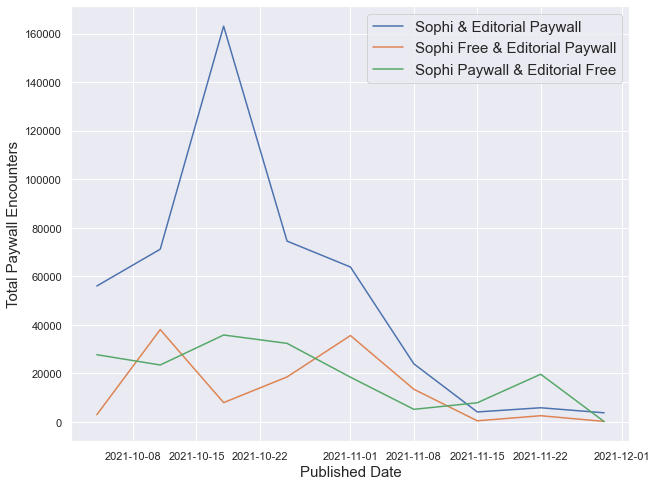

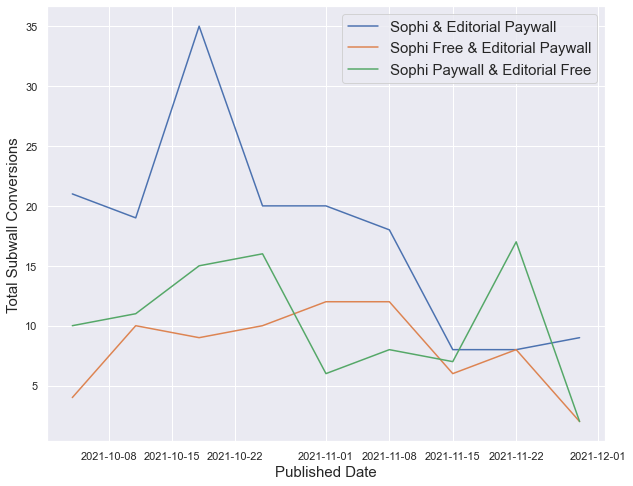

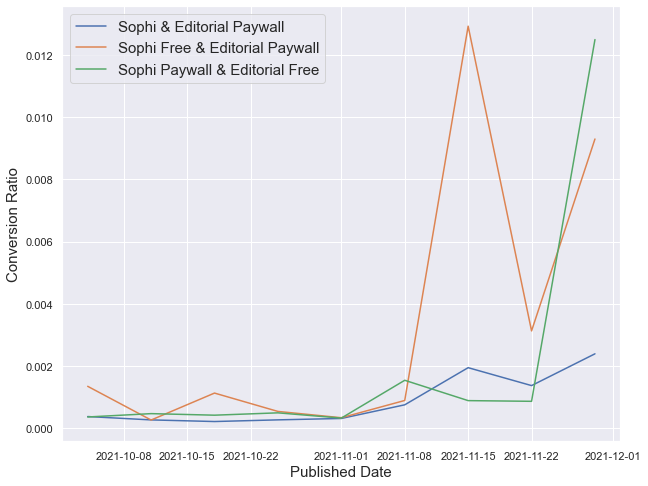

In [6]:
for i in range(len(lst)):
    plt.figure()
    plt_lst[i] = sns.lineplot(x=df_grp['Published Date'],y=df_grp[lst[i]],hue=df_grp['Paywall Category'])
    plt_lst[i].set_xlabel('Published Date', fontsize = 15)
    plt_lst[i].set_ylabel(y_label_lst[i], fontsize = 15)
    plt.legend(fontsize = 15)

In [7]:
# From the Conversion Ratio by Published Date plot above, there is a sharp jump on Week 46 (Nov 15 to 21). It should be
# an outlier. The 7-days rolling average will eliminate the outlier effect.
# The following code calculate 7-days rolling average of paywall encounters, subwall conversions and conversion ratio
df['r_PE'] = df['Paywall Encounters'].rolling(7).mean()
df['r_SC'] = df['Subwall Conversions'].rolling(7).mean()
df_rolling = df.dropna()
df_r_grp = df_rolling.groupby(['Paywall Category', pd.Grouper(key='Published Date', freq='W-MON')])['r_PE','r_SC'].sum()
df_r_grp['ratio'] = df_r_grp['r_SC']/df_r_grp['r_PE']
df_r_grp = df_r_grp.reset_index()
df_r_grp.head()

C:\Users\DTONG\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


,Paywall Category,Published Date,r_PE,r_SC,ratio
0,Sophi & Editorial Paywall,2021-10-04,52196.000000,17.571429,0.000337
1,Sophi & Editorial Paywall,2021-10-11,40552.000000,14.000000,0.000345
2,Sophi & Editorial Paywall,2021-10-18,120640.571429,33.285714,0.000276
3,Sophi & Editorial Paywall,2021-10-25,66973.142857,24.285714,0.000363
4,Sophi & Editorial Paywall,2021-11-01,59164.428571,17.571429,0.000297


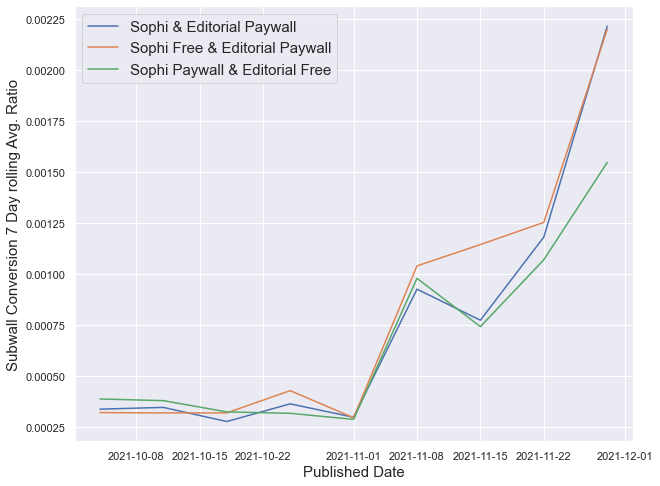

In [8]:
p = sns.lineplot(x=df_r_grp['Published Date'],y=df_r_grp['ratio'],hue=df_r_grp['Paywall Category'])
p.set_xlabel("Published Date", fontsize = 15)
p.set_ylabel("Subwall Conversion 7 Day rolling Avg. Ratio", fontsize = 15)
plt.legend(fontsize = 15)

In [9]:
# The 7-days rolling average fixed the outliers. The blue and green lines are close together. However,
# the orange line (Sophi Free & Editorial Paywall) is slightly higher than the other 2 lines, especially 
# higher at week 46. Paired t-test is the best way to tell if there is any differnece between 3 paywall categories

In [10]:
# Prepare dataset for t-test
df_SPEP = df_r_grp[df_r_grp['Paywall Category'] == 'Sophi & Editorial Paywall']['ratio']
df_SFEP = df_r_grp[df_r_grp['Paywall Category'] == 'Sophi Free & Editorial Paywall']['ratio']
df_SPEF = df_r_grp[df_r_grp['Paywall Category'] == 'Sophi Paywall & Editorial Free']['ratio']

In [11]:
stats.shapiro(df_SPEP)

ShapiroResult(statistic=0.7668371200561523, pvalue=0.008492120541632175)

In [12]:
stats.shapiro(df_SFEP)

ShapiroResult(statistic=0.8007001876831055, pvalue=0.02080046385526657)

In [13]:
stats.shapiro(df_SPEF)

ShapiroResult(statistic=0.8344186544418335, pvalue=0.05004362761974335)

In [14]:
stats.ttest_rel(df_SPEP, df_SFEP)

Ttest_relResult(statistic=-1.6208869563132153, pvalue=0.143700358645536)

In [15]:
stats.ttest_rel(df_SPEP, df_SPEF)

Ttest_relResult(statistic=0.9974895147666768, pvalue=0.34773775279555)

In [16]:
stats.ttest_rel(df_SFEP, df_SPEF)

Ttest_relResult(statistic=1.7856313753958257, pvalue=0.11198394954500018)

In [17]:
# According to the paired t-test result, all p-values are greater than 0.05. Then failed to reject null hyposis. 
# Conslusion: there is no significant difference between 3 categories statistically.

C:\Users\DTONG\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'Content Counts')

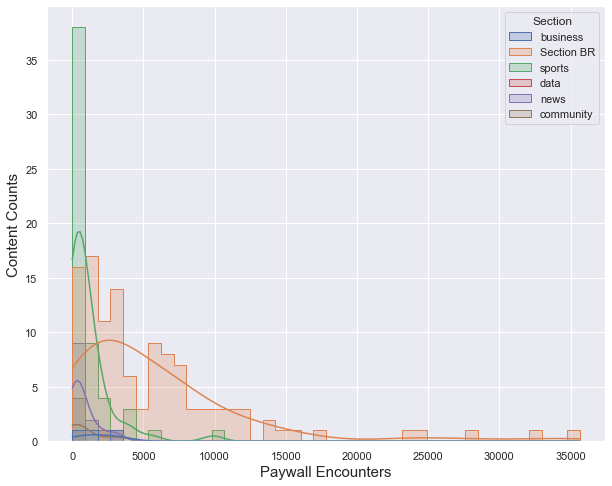

In [18]:
# More exploring on paywall encounters on each contents
p = sns.histplot(data=df, x="Paywall Encounters",hue='Section',bins=40,kde=True, element="step")
p.set_xlabel("Paywall Encounters", fontsize = 15)
p.set_ylabel("Content Counts", fontsize = 15)

In [19]:
# Looking into PE and SC relationship with Days of weeks
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_df_section = df.groupby([df['Published Date'].dt.day_name(),'Section'])['Paywall Encounters','Subwall Conversions'].sum().reset_index().sort_values(by='Published Date')
week_df_section.head()

C:\Users\DTONG\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Published Date,Section,Paywall Encounters,Subwall Conversions
0,Friday,Section BR,64576,20
1,Friday,business,1768,1
2,Friday,news,718,3
3,Friday,sports,523,2
4,Monday,Section BR,171349,61


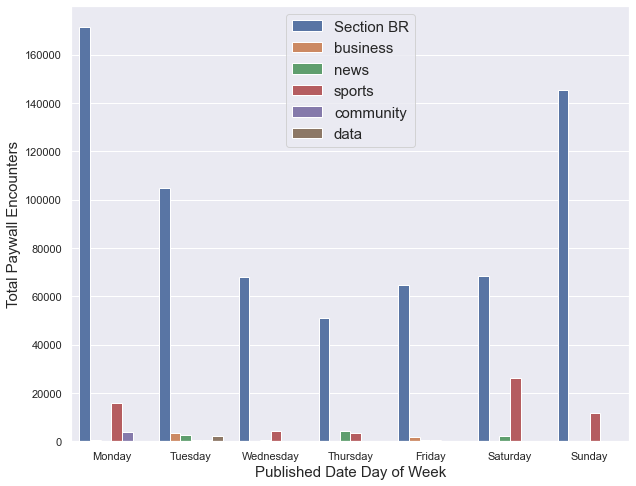

In [20]:
p4 = sns.barplot(x='Published Date', y="Paywall Encounters", data=week_df_section,hue='Section',order=cats)
p4.set_xlabel("Published Date Day of Week", fontsize = 15)
p4.set_ylabel("Total Paywall Encounters", fontsize = 15)
plt.legend(fontsize = 15,loc='upper center')

In [21]:
df_content_ID = df.groupby(['Section'])['Content ID'].count().reset_index()
df_content_PE = df.groupby(['Section'])['Paywall Encounters','Subwall Conversions'].sum().reset_index()
df_content = df_content_ID.merge(df_content_PE)
df_content['ratio'] = df_content['Subwall Conversions']/df_content['Paywall Encounters']
df_content.style.format({'ratio': '{:,.2%}'.format,})

C:\Users\DTONG\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Section,Content ID,Paywall Encounters,Subwall Conversions,ratio
0,Section BR,116,672906,222,0.03%
1,business,3,5368,4,0.07%
2,community,5,4274,8,0.19%
3,data,1,2244,1,0.04%
4,news,13,10247,20,0.20%
5,sports,56,61656,68,0.11%


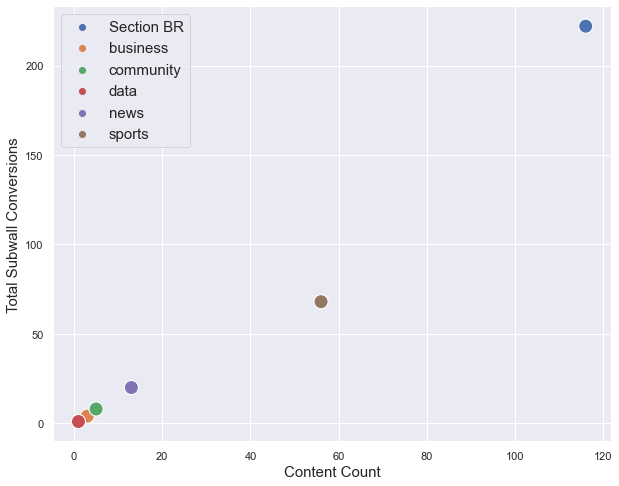

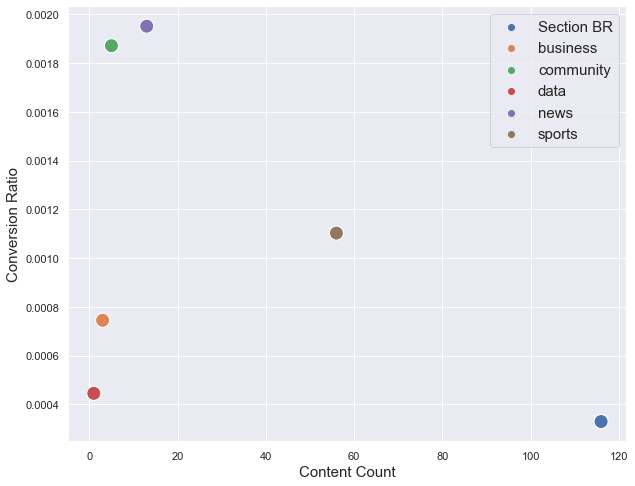

In [22]:
for i in range(len(lst)-1):
    plt.figure()
    plt_lst[i+1] = sns.scatterplot(data=df_content, x='Content ID',x_bins = 30,y=lst[i+1], hue="Section",s=200)
    plt_lst[i+1].set_xlabel("Content Count", fontsize = 15)
    plt_lst[i+1].set_ylabel(y_label_lst[i+1], fontsize = 15)
    plt.legend(fontsize = 15)

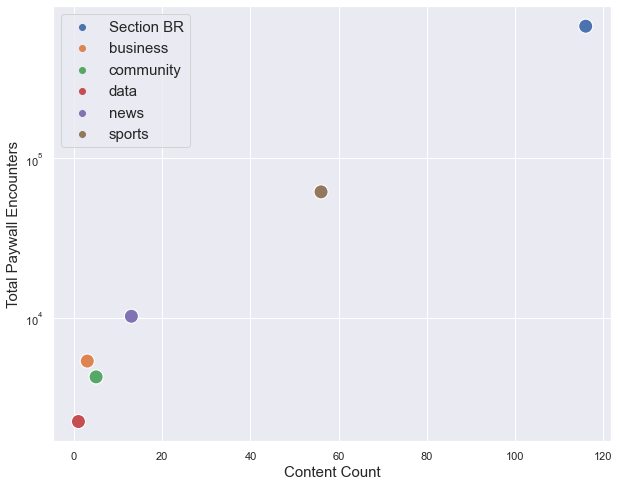

In [23]:
f, ax = plt.subplots()
# Set y axix to log since Section BR had way more paywall encounters
ax.set(yscale="log")
p5 = sns.scatterplot(data=df_content, x='Content ID',x_bins = 30,y='Paywall Encounters', hue="Section",s=200)
p5.set_xlabel("Content Count", fontsize = 15)
p5.set_ylabel("Total Paywall Encounters", fontsize = 15)
plt.legend(fontsize = 15)

In [24]:
# End of notebook